# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

---
## Students

* Team: 6
* Students: Gabor Csordas, Maëlle Le Clainche, Nicolas Fontbonne, Marie Sadler
* Dataset: Flights routes

---
## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

---
## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

---
## 0 Load your network

In [2]:
%matplotlib inline

*If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).*

In [3]:
import numpy as np
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg
import matplotlib as mpl
mpl.style.use('seaborn')
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# for ground truth checking
import pandas as pd

*Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.*

*Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)*

In [22]:
adjacency =  np.load("../data/adjacency_sym_mtx.npy")
adjacency_unweighted = np.copy(adjacency)
adjacency_unweighted[adjacency_unweighted!=0]=1
degrees = np.sum(adjacency_unweighted, axis = 0)
n_nodes =  adjacency_unweighted.shape[0]
## We are removing those edges where the weight is smaller thane the threshold
threshold = 20
node_map = np.where(degrees >= threshold)[0]
adjacency_th = np.delete(adjacency_unweighted,np.where(degrees < threshold),0)
adjacency_th = np.delete(adjacency_th,np.where(degrees < threshold),1)
degrees_th = np.sum(adjacency_th, axis = 0)
n_nodes_th = adjacency_th.shape[0]

adjacency_csr = sparse.csr_matrix(adjacency_unweighted);
degree_matrix_csc = sparse.diags(degrees,format = "csc")

---
## 1 Graph Laplacian

---
### Question 1

*From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.*

*Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.*

*For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).*

In [23]:
laplacian_combinatorial_csr =  sparse.csr_matrix(degree_matrix_csc - adjacency_csr);
inv_degree_matrix_csr = sparse.linalg.inv(degree_matrix_csc).tocsr()
sqrt_inv_degree_matrix_csr = sparse.csr_matrix.sqrt(inv_degree_matrix_csr)
laplacian_normalized_csr = sqrt_inv_degree_matrix_csr * laplacian_combinatorial_csr * sqrt_inv_degree_matrix_csr

*Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!*

In [24]:
laplacian = laplacian_normalized_csr

---
### Question 2

*Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.*

*Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.*

In [26]:
# calculate eigenvalues and eigenvectors
[eigenvalues, eigenvectors] = sparse.linalg.eigsh(laplacian_normalized_csr, k = n_nodes-1, which = 'LM')

#This function will not return the first eigenvalue 0 because we know that the first eigenvalue is always 0
#So when we now look at eigenvalues we should not forget that there is one more 0.

# sort the resulting values and vectors
sortID = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sortID]
eigenvalues[eigenvalues < 10**(-10)] = 0

eigenvectors = eigenvectors[:,sortID]
eigenvectors[eigenvectors < 10**(-10)] = 0

* *Justify your choice of eigensolver.*

**Answer**


The Laplacian is always a symmetric real valued matrix and therefore a Hermitian matrix as well. So we can use the solver for sparse Hermitian matrices.

---
### Question 3

* *We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?*

**Answer**

The matrix S is the incidence matrix having as rows the nodes and as columns the edges ($S \in \mathbb{R}^{NxM}$, N the number of nodes and M the number of edges). For an unweighted graph, $S_{i,j}$ = 1, for an edge $e_j$ between two vertexes $v_{i,k}$, -1 for $e_j$ between $v_{k,i}$ and 0 otherwise (the choice of sign is arbitrary, but it has to be once positive and once negative for a given edge). For a weighted graph, the entries are $\sqrt{w_{i,k}}$ and $-\sqrt{w_{i,k}}$, instead of +1 and -1, respectively. 

$S^\top$ acts as a graph gradient, and $S^\top x$ for a weighted graph computes:

\begin{equation}
(S^\top x )[j]= \sqrt{w_{i,k}} (x[i] - x[k])
\end{equation}

which corresponds to the derivative of x along edge j

---
### Question 4

* *Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).*

**Answer**

\begin{equation} 
\begin{split}
\lambda_k & = u_k^\top L u_k \text{, result of the eigendecomposition of $L$ with $u_k$ being a unit-vector}\\ 
 & = u_k^\top S S^\top  u_k \text{      , with $L = S S^\top$}\\
 & = (S^\top u_k)^\top S^\top  u_k \text{        , where the order of factors reverses when taking the transpose}\\
 & =\| S^\top u_k \|_2^2 \text{     , with $x^\top x$ being the squared Euclidean norm}\\
\end{split}
\end{equation} 

* *What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?*

**Answer**

This quantity tells us how "smooth" x is, i.e. a larger quantity means a higher variation among the x vector components.

---
### Question 5

* *What is the value of $u_0$, both for the combinatorial and normalized Laplacians?*

**Answer**

 * **Combinatorial Laplacian**

$u_0$ corresponds to the eigenvalue 0 and cannot be the vector 0. From the definition of the eigendecomposition we have:

\begin{equation}
L u_0 = \lambda_0 u_0 = 0 
\end{equation}

Multiply by $u_0^\top$ gives: 
\begin{equation}
u_0^\top L u_0 = u_0^\top \cdot 0 = 0
\end{equation}

Since $u_0^\top L u_0$ is defined as follows:
\begin{equation}
u_0^\top L u_0 = \frac{1}{2} \sum_{\substack{u,v} \in E} w_{u,v}(u_0[u]-u_0[v])^2
\end{equation}

We get: 
\begin{equation}
\sum_{\substack{u,v} \in E} w_{u,v}(u_0[u]-u_0[v])^2 = 0 
\end{equation}

For this equation to hold, we need to have $u_0[u] = u_0[v]$ for any edge (u,v) $\in E$. In the case where the graph is connected, we get that $u_0[i] = u_0[k]$ for every i,k $\in V$. From this we get that $u_0$ equals: 
\begin{align}
    u_0 &= \alpha \begin{bmatrix}
           1 \\
           1 \\
           \vdots \\
           1
         \end{bmatrix}
  \end{align}

with $\alpha \in \mathbb{R}^*$, or to have a unit vector, $\alpha$ needs to equal $\alpha = \frac{1}{\sqrt{N}}$, where $N$ is the number of connected nodes. Thus, the value of $u_0$ is the unit vector $e$. 

- **Normalized Laplacian**

Let's call $u_0'$ the eigenvector of the normalized Laplacian $L_{norm}$.

From the theory, we know that $u_0' = D^{\frac{1}{2}} u_0$, and hence $u_0' =  D^{\frac{1}{2}} e$ is the eigenvector of $L_{norm}$ of eigenvalue 0.

---
### Question 6

- *Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.*

Text(0, 0.5, 'Eigenvalue')

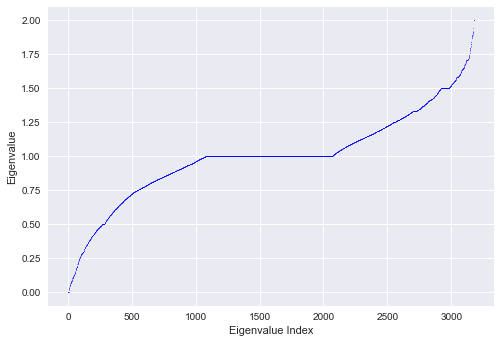

In [27]:
plt.plot(eigenvalues.real, "b." , markersize = 1)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')

**Answer**

As espected the eigenvalues are in the domain $[0,2]$. The first eigenvalues which equal to 0 represent the number of connected components. 

It is interesting to observe that a lot of eigenvalues equal 1. In this notebook we will not further investigate into this property, but we will keep it in mind for the final report. 


- *How many connected components are there in your graph? Answer using the eigenvalues only.*

In [28]:
# in addition to the 0-multiplicity we add 1 which corresponds to the first eigenvalue 0 which is omitted in the computation
n_conn_comp = eigenvalues[eigenvalues == 0].shape[0] + 1 
print("Number of connected components:",n_conn_comp)

Number of connected components: 7


There are **8** connected components.

- *Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.*

**Answer**

For normalized Laplacians the upper bound on the eigenvalues is 2, where equality holds iff the graph is bipartite. 

For our graph (normalized graph and the threshold graph), we observed that the upper bound of the eigenvalues of the combinatorial Laplacian was the same than the maximum degree. Defining the upper bound is an active field of research, and diverse theorems of tight bounds can be found in the literature.

---
## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

---
### Question 7

* *What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)*

**Answer**

We use Laplacian eigenmaps for **dimensionality reduction**. Often, graph data is intrinsically low dimensional, but lies in a very high-dimensional space. Thus, **mapping a network to a vector space and reducing the dimension, while preserving relevant graph properties**, can be useful for faster **computation, machine learning algorithms, statistics, or visualization**.  

---
### Question 8

*Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.*

*Recompute the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.*

In [29]:
#Creating the matrix in the good format
adjacency_lc_csr = sparse.csr_matrix(adjacency_th);
degrees_lc = np.sum(adjacency_th, axis = 0)
degree_matrix_lc_csc = sparse.diags(degrees_lc,format = "csc")
n_nodes_lc =  degrees_lc.shape[0]

#Computation of the laplacian for our graph
laplacian_combinatorial_lc_csr =  sparse.csr_matrix(degree_matrix_lc_csc - adjacency_lc_csr);
inv_degree_matrix_lc_csr = sparse.linalg.inv(degree_matrix_lc_csc).tocsr()
sqrt_inv_degree_matrix_lc_csr = sparse.csr_matrix.sqrt(inv_degree_matrix_lc_csr)
laplacian_normalized_lc_csr = sqrt_inv_degree_matrix_lc_csr * laplacian_combinatorial_lc_csr * sqrt_inv_degree_matrix_lc_csr


In [30]:
def graph_embedding(laplacian_normalized_csr, d):
    [eigenvalues, eigenvectors] = sparse.linalg.eigsh(laplacian_normalized_csr, k = d+1, which = 'SM')
    sortID = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sortID]
    eigenvectors = eigenvectors[:,sortID]
    proj  = eigenvectors[:,1:d+1]
    return proj

* *Plot the nodes embedded in 2D. Comment on what you see.*

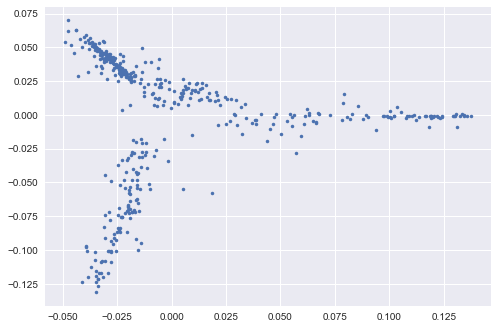

In [45]:
proj = graph_embedding(laplacian_normalized_lc_csr,  2)
plt.plot(proj[:,0],proj[:,1], '.')

**Answer**

With the embedding in two dimensions, airports that are connected by a flight now appear close to each other in the plot. We start to see clusters that naturally emerge form the geometry. Since the clusters represent airports that are well connected to each other, there might be another meaning to it such as financially, economically, and culturally similar countries.

---
### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Answer**

The embedding $Z \in \mathbb{R}^{N \times d}$ preserves relevant graphs properties such as the number of data points N, while reducing the dimension d. 
The goal of the Laplacian eigenmap algorithm is to preserve local information optimally. All the point node that are close to each other, meaning nodes connected by an edge with a large weight, must remain close to each other in the embedding.

---
## 2 Spectral clustering

*Spectral clustering is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.* 

For this part, we have chosen to use the unweighted adjacency matrix, because we feel that our graph will probably be clustered according to geographical features. Moreover we kept only the nodes with a degree larger than 20, because we want to see only the airports (=nodes) that are significant (an airport with less than 20 flights is not very significant). By applying this threshold, we also assure that our graph is connected.

In [32]:
#Computation of the eigenvalues and eigenvectors for our graph
[eigenvalues_lc, eigenvectors_lc] = sparse.linalg.eigsh(laplacian_normalized_lc_csr, k = n_nodes_lc-1, which = 'LM')
#This function will not return the first 0 because it is assuming it is always there. 
#So when we now look at eigenvalues we had not to forget that there is one more 0.
sortID = np.argsort(eigenvalues_lc)
eigenvalues_lc = eigenvalues_lc[sortID]
eigenvectors_lc = eigenvectors_lc[:,sortID]

In [33]:
n_conn_comp = eigenvalues_lc[eigenvalues_lc ==  0].shape[0]+1
eigenvalues_lc[eigenvalues_lc < 10**(-10)] = 0
print("Number of connected components:",n_conn_comp)

Number of connected components: 1


Text(0, 0.5, 'Values of eigenvalues')

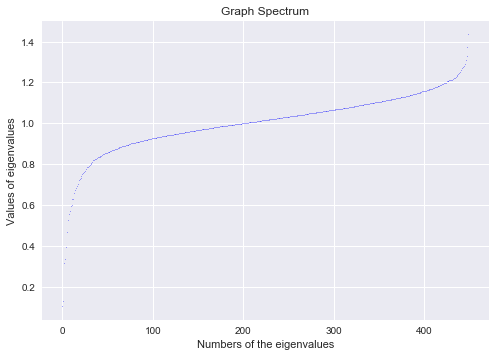

In [34]:
# Graph Spectrum
plt.plot(eigenvalues_lc, "b." , markersize = 1)
plt.title("Graph Spectrum")
plt.xlabel("Numbers of the eigenvalues")
plt.ylabel("Values of eigenvalues")

---
### Question 10

* *Choose $k$ and $d$. How did you get to those numbers?*

**Answer**
- k is chosen according to the graph of eigenvalues : the number of eighenvalues before the "gap" corresponds to k. k is the number of clusters.
- d is the dimension of the embedding space, it has to be chosen in order to preserve local infomation optimally in a certain sense. (after Belkin's book).

number of eigenvalues before 1st gap : 3
number of eigenvalues before 2nd gap : 6


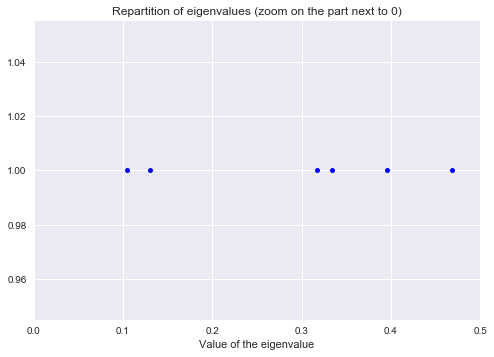

In [35]:
#Plot eigenvalues repartitions
x = np.ones_like(range(len(eigenvalues_lc)))
plt.plot(eigenvalues_lc,x,"b.",markersize = 10)
plt.xlim([0,0.5])
plt.title("Repartition of eigenvalues (zoom on the part next to 0)")
plt.xlabel("Value of the eigenvalue")

##count how many values we have until the gap
nb_before_1rst=len(eigenvalues_lc[np.where(eigenvalues_lc< 0.2)])+1 # +1 correspond to the first 0 not in the list of eigenvalues
nb_before_2nd=len(eigenvalues_lc[np.where(eigenvalues_lc< 0.4)])+1  # +1 correspond to the first 0 not in the list of eigenvalues
print("number of eigenvalues before 1st gap :",nb_before_1rst)
print("number of eigenvalues before 2nd gap :",nb_before_2nd)

- As we see on the graph, we have two big gaps. The first corresponds to k=3 and the second to k=6. We will test these two possibilities
- We have decided to take d=k, because d is the number of eigenvectors to keep when applying the K-means. If d<k, the number of information may be to little to process a good clustering. However if d is large, the computational cost will be higher. Considering these facts, d=k seems a good compromise.

---
### Question 11

1. *Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.*
1. *If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.*

We choose to do the embedding with the eigenvectors obtained from the eigendecomposition of the normalized Laplacian.

In [59]:
# For k=3 and d=3
k = 3; d = 3
H = eigenvectors_lc[:,:d]; 
clusters3 = KMeans(n_clusters=k, random_state=0).fit_predict(H)

print("----- For k=",k," and d=",d," -----")
print("Number of elements in clusters :")
for i in range(k):
    cnt = 0
    for j in clusters3:
        if j == i:
            cnt +=1
    print("Cluster ",i+1,":",cnt)

#For k=6 and d=6
k = 6; d = 6
H = eigenvectors_lc[:,:d]; 
clusters6 = KMeans(n_clusters=k, random_state=0).fit_predict(H)
print()
print("----- For k=",k," and d=",d," -----")
print("Number of elements in clusters :")
for i in range(k):
    cnt = 0
    for j in clusters6:
        if j == i:
            cnt +=1
    print("Cluster ",i+1,":",cnt)


----- For k= 3  and d= 3  -----
Number of elements in clusters :
Cluster  1 : 280
Cluster  2 : 60
Cluster  3 : 111

----- For k= 6  and d= 6  -----
Number of elements in clusters :
Cluster  1 : 11
Cluster  2 : 105
Cluster  3 : 93
Cluster  4 : 167
Cluster  5 : 25
Cluster  6 : 50


In [60]:
#For k=2, we have :
fiedler_vect = np.sign(eigenvectors_lc[:,0])
nb_neg=len(fiedler_vect[np.where(fiedler_vect==-1)])
nb_pos=len(fiedler_vect[np.where(fiedler_vect==1)])
print("----- For k=2 (this is just an exemple, it has no real sense for our graph) -----")
print("Number of elements in clusters :")
print("Cluster labeled +1 :",nb_pos)
print("Cluster labeled -1 :",nb_neg)

----- For k=2 (this is just an exemple, it has no real sense for our graph) -----
Number of elements in clusters :
Cluster labeled +1 : 143
Cluster labeled -1 : 308


---
### Question 12

- *Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?*

Text(0.5, 1.05, 'Reordered ajacency matrix for k=6')

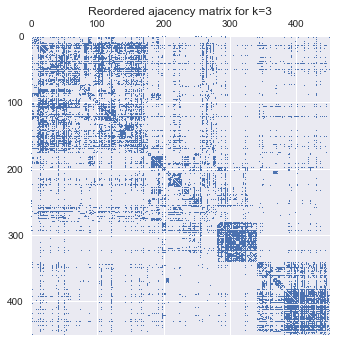

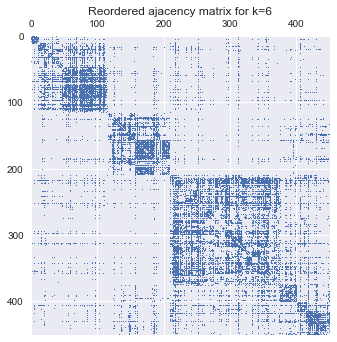

In [61]:
# For k=3
new_order3 = np.array([],dtype = int)
for i in range(3):
    new_order3 = np.append(new_order3,np.where(clusters3 == i))
plt.spy(adjacency_th[:,new_order3][new_order3], markersize=1)
plt.title("Reordered ajacency matrix for k=3")

#For k=6
plt.figure()
new_order6 = np.array([],dtype = int)
for i in range(6):
    new_order6 = np.append(new_order6,np.where(clusters6 == i))
plt.spy(adjacency_th[:,new_order6][new_order6], markersize=1)
plt.title("Reordered ajacency matrix for k=6")

We were expecting a block diagonal matrix or something close to it, because the nodes of one cluster are supposed to be mostly connected with the nodes of this same cluster. Of course the clusters are not fully independent (in this case, our graph would have several distinct components).
- For k=3, we observe 3 blocks in the diagonal. However, those blocks seems to have "internal" blocks : that means that it may exist some "internal" clusters in clusters. This is fully visible in the case k=6.
- For k=6, the diagonal is composed of 6 blocks. Some blocks (like the 3rd - 167 nodes) are much bigger than others (like the 2nd - 11 nodes). The blocks are still connected with the other blocks even if they are mostly link with themselves.

---
### Question 13

*If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.*

*Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).*

Since there are no labels in our dataset, we have chosen to check our hypothesis of geographical clusters. In order to do that we import back our dataframe of airports and flights.

In [62]:
# import of routes
routes = pd.read_csv('../data/routes.dat', sep=',', encoding='utf-8', engine='python')
routes.columns = ['Airline','Airline ID','Source Airport','Source Airport ID','Destination Airport','Destination Airport ID','Codeshare','Stops','Equipment']
routes = routes.drop(columns=['Source Airport ID','Destination Airport ID'])

# import of source and destination airport
source_airports = routes[['Source Airport']]
source_airports = source_airports.rename(columns={'Source Airport':'Airport'})

dest_airports = routes[['Destination Airport']]
dest_airports = dest_airports.rename(columns={'Destination Airport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airports = pd.concat([source_airports,dest_airports])
airports = airports.drop_duplicates()
airports.reset_index(inplace=True)
airports = airports.drop(columns=['index'])
airports.reset_index(inplace=True)
airports = airports.set_index('Airport')
airports = airports.rename(columns={'index':'airport_idx'})

In [63]:
#For clustering with k=3
print("--------------------------------- For k=3 ---------------------------------\n")

for i in range(3):
    print("Cluster",i+1," :\n",airports.index[node_map[np.where(clusters3 == i)]].values)

--------------------------------- For k=3 ---------------------------------

Cluster 1  :
 ['GYD' 'SVX' 'FNA' 'YIK' 'YUL' 'YWB' 'JIB' 'MGQ' 'KUL' 'SGN' 'TPE' 'FDH'
 'FMM' 'MUC' 'SZG' 'ZAD' 'ATL' 'BIM' 'ELH' 'EYW' 'FLL' 'GGT' 'GHB' 'GLH'
 'GNV' 'JAX' 'MHH' 'TLH' 'TUP' 'CUR' 'BHK' 'KSQ' 'NVI' 'SKD' 'TIV' 'ANU'
 'DOM' 'SBH' 'SDQ' 'SFG' 'SLU' 'CGO' 'CSX' 'CZX' 'DNH' 'DYG' 'FOC' 'HDG'
 'JGN' 'JJN' 'KHG' 'KMG' 'KOW' 'KWE' 'LJG' 'LYI' 'LZY' 'NZH' 'SPN' 'TSN'
 'XIY' 'YIH' 'YTY' 'YVR' 'ZHA' 'ZHY' 'ZUH' 'LAS' 'MCG' 'NIB' 'TLJ' 'TJM'
 'EZE' 'YYC' 'CJS' 'PVR' 'SAT' 'ZIH' 'BGO' 'KGS' 'PMO' 'PSA' 'PUY' 'RAK'
 'SPU' 'TUN' 'VCE' 'AKP' 'MLY' 'KUK' 'KWK' 'WWT' 'MGA' 'PJM' 'JUB' 'LAU'
 'LOK' 'MBA' 'BKI' 'BWN' 'CEB' 'CGK' 'CYZ' 'DPL' 'HAN' 'ILO' 'NGO' 'NRT'
 'PAG' 'USU' 'VRC' 'MMK' 'SCW' 'ANF' 'YCO' 'YEK' 'YFB' 'YRT' 'YTE' 'YUX'
 'YWG' 'YYQ' 'YZS' 'BZE' 'PBZ' 'AMD' 'BDQ' 'HYD' 'IXC' 'IXR' 'TRV' 'VTZ'
 'SGD' 'YPC' 'YUB' 'KRR' 'PYJ' 'KAW' 'MGZ' 'NYU' 'SNW' 'THL' 'TVY' 'EVN'
 'RTW' 'CJJ' 'GUM' 'GWT' 'YHY' 'Y

For k=3, we observe that our cluster are relative to the continents.
- **Cluster 1:** European Airports (ex : Geneva, Lyon, Dublin, Rome, Vienne etc) + some Indonesian Airports (Jawa Timur, Jakarta)
- **Cluster 2:** American Continent Airport (ex : Peru, America, Canada etc)
- **Cluster 3:** Asian Continent (ex : China, Japan)

We notice that some airports are badly clustered if we consider geographical clusters : for exemple ITM (Osaka Airport, Japan) is in Cluster 1 ("Europe"). Moreover the "mix" of geographic areas in cluster 1 really shows that some in-clusters exist. Choosing a higher k will probably show a result closer to the geographical "reality".

In [64]:
#For clustering with k=6
print("--------------------------------- For k=6 ---------------------------------\n")

for i in range(6):
    print("Cluster",i+1," :\n",airports.index[node_map[np.where(clusters6 == i)]].values)

--------------------------------- For k=6 ---------------------------------

Cluster 1  :
 ['UIP' 'BRO' 'BUF' 'CHC' 'COS' 'CRP' 'DSM' 'FNT' 'GPT' 'GRI' 'LNJ']
Cluster 2  :
 ['PEM' 'BDS' 'HAD' 'KSD' 'GES' 'SUG' 'TUG' 'RAO' 'HYL' 'FRU' 'LBD' 'SHJ'
 'BFQ' 'OTD' 'KVX' 'OLH' 'ORI' 'TCZ' 'YBL' 'YWL' 'YZZ' 'GNY' 'ODS' 'BRC'
 'REL' 'KBC' 'JAN' 'LSE' 'MFE' 'SBA' 'TRI' 'YKF' 'LCY' 'MLA' 'PVK' 'SVQ'
 'STG' 'WRG' 'YAK' 'YKM' 'AHU' 'OUD' 'TTA' 'VIL' 'AXM' 'BAQ' 'BGA' 'EYP'
 'NVA' 'SMR' 'VUP' 'KAJ' 'KEF' 'OPO' 'TLL' 'TMP' 'VAA' 'AAL' 'CIY' 'KRT'
 'TGD' 'TRS' 'TSE' 'BQN' 'ORH' 'KSH' 'RAS' 'THR' 'DUR' 'GRX' 'PLZ' 'SSB'
 'BRR' 'CFN' 'DSA' 'INV' 'KOI' 'WAT' 'JXA' 'LLF' 'TEN' 'YNT' 'DAD' 'EBJ'
 'MUB' 'KMQ' 'PLQ' 'BNC' 'FBM' 'GMA' 'IRP' 'KOO' 'AKU' 'DQA' 'GYS' 'HLD'
 'HSN' 'JGS' 'JIU' 'JNZ' 'SDL' 'KOP' 'ABR' 'BSR' 'YAY']
Cluster 3  :
 ['GYD' 'HSG' 'TYS' 'CGI' 'EIS' 'RUT' 'IXM' 'IXS' 'KWI' 'RAJ' 'YYZ' 'JIK'
 'PHL' 'RIB' 'TJA' 'AGF' 'BVE' 'ETZ' 'JPA' 'PHB' 'XAP' 'DAL' 'ENH' 'JRO'
 'KBV' 'LGG' 'NSI' 'PHC' 'E

For k=6, we observe that our clusters are more relative to smaller areas (countries or region of countries).
- **Cluster 1:** North and Central America (Peru, Colombia, and a lot of cities of the USA)
- **Cluster 2:** South Ameria (Bresil, Argentine)
- **Cluster 3:** Europe (France, Switzerland, Italy, UK, etc)
- **Cluster 4:** Asia and Indonesia (Phillipines, Thailande, Chine, Japon, etc)
- **Cluster 5:** Africa (Cote d'Ivoire, Egypt, Arabie Saoudite, Iran, etc)
- **Cluster 6:** Russia (+ some countries linked to Russia like Kazakhstan)

This clustering is really qualitative and shows some meaningful relations between countries. The case of Russia is quite revealing : it is a separate cluster and includes a lot of countries from the former Soviet Union.

---
### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

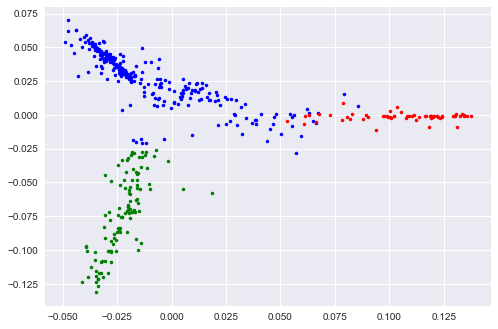

In [67]:
colors = ['Blue', 'Red', 'Green']

for i in range(3):
    cluster = proj[np.where(clusters3 == i)[0], :].real
    plt.plot(cluster[:,0],cluster[:,1], '.', color=colors[i])

**Answer**

- **Blue :** Europe + Indonesia (Jawa Timur, Jakarta)
- **Red :** America
- **Green :** Asia

---
### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Answer**

The eigenvectors give the embedding of the node in a lower dimensional space keeping similar nodes (in the sense of their egde weigth) close together. Similar nodes are close to each other considering the $L-$distance used for the $k$-mean clustering. Therefore, the eigenvectors are good choice for clustering nodes. 

We could have used other features, such as the eigenvectors of the adjacency matrix. 